# Pareto Front Fundamentals With The Knapsack Problem


<img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/Knapsack.svg" width=250>

This notebook may be used in Google Colab. To access press this button:

<a href="https://bit.ly/pareto-front-colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="First: Open In Colab"/></a>

Here you will use the Knapsack Problem to learn about Pareto Fronts.

**Main Take Aways**.   
* Optimisation concepts *Decision Spaces* and *Objective Spaces*: you will learn what they are and how to define these for the knapsack problem.
* The limitations of the commonly practiced Single Objective Optimisation.  
* Pareto Fronts: identifying by eye Pareto optimal solutions within a distribution as well as pseudocode for selecting these *Non-Dominated* solutions.



**The Knapsack Problem**   
In this challenge you will fill virtual knapsacks with packages that have monetary value and weight.   
The objective is to minimise the final weight of the knapsack and maximise the total monetary value of its contents.    
(You will also be able to change the objectives from min-max to the other options: max-max and min-min, max-min.)

**Recommended Notebook Usage**

We recommend doing each of the following steps at a time and answer the summary questions to ensure that the main lessons have been learned. 

<ul>
      
<details>
        <summary>Setup</summary> 
            Understand the data setup of packages and how they relate to the knapssacks 
</details>
    
<details>
        <summary>Decision and Objective Spaces</summary> 
            These optimisation concepts have not been introduced in the previous videos (but will appear in summary video).<br>Try to understand what they are and how they relate to the knapsack problem.  
</details>
    
<details>
        <summary>Single Objective Optimisation</summary> 
            Here you will create a 1D heuristic and apply Single Objective Optimistion. 
</details>
    
<details>
        <summary>Pareto Optimisation</summary> 
            The fun part! We will identify Pareto Optimal solutions within a distribution. To appreciate how it works try to understand the Pareto Front pseudocode.
</details>
    
</ul>
    
There is no need to understand every line of Python, especially in the first run! Reading the cell headers is sufficient to understand what a cell does.  It is more important to understand the text in the Markdown cells and the visuals created.  

We recommend doing the first run until the [Summary](#Summary) section as is. 
Afterwhich we recommend that you explore different types of results by modfiying the variables flagged with ***CHANGE ME!***. We list in the [Summary](#Summary) section suggested actions to take, but feel free to be creative!

**Note!**  
For simplicity, in this notebook, we will explore an exhaustive solution space, i.e, one where we can brute force our way to 
all the solutions.  

<img src="https://tinyurl.com/vrdj29w9" width="700">  

**One final note for PyCon USA participants**  

Don't worry if you don't manage to to go through everything in depth during the allocated time. You will be able to access to this notebook later.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# setting up definitions for visuals 

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = 12, 8

# Packages 

Let's create some data!

<img src="https://uk.packsize.com/wp-content/uploads/sites/11/2015/05/wp-boxes.jpg" width=300>

Here we create packages by defining for each its weight and monetary value according to a distribution.   

Parameters of interest:  
* `N_PACKAGES` - the total number packages to choose from.  
* `value_distribution_mode` - indicates the relationship between the package weight and monetary value.   
The weights are randomly distributed where: 
    * `value_distribution_mode=random` - monetary value distribution also random
    *  `value_distribution_mode=squared` - monetary value is squared that of the weights (up to some noise quantified by `noise_factor`).  
    
This will results in 
* `packages` a dictionary containing information of the `N_PACKAGES` packages.
 It has the form `{key: package}`, where each package have the form `{'weight': weight, 'value': value}`

In [3]:
seed = 3141592653 # CHANGE ME! to get a different distribution

N_PACKAGES = 20   # CHANGE ME! the total number of packages to choose from

WEIGHT_MEAN = 0.1 # CHANGE ME! the mean of the weight distribution
WEIGHT_SD = 10    # CHANGE ME! the standard deviation of the weight distribution

VALUE_MEAN = 0.1  # CHANGE ME! when value_distribution_mode='random': the mean of the monetary value distribution 
VALUE_SD = 100    # CHANGE ME! when value_distribution_mode='random': the standard deviation of the monetary value distribution 

value_distribution_mode = 'random' # CHANGE ME! options: 'random', 'squared'
noise_factor = 1./2  # CHANGE ME! when value_distribution_mode='squared': the standard deviation of the noise introduced
# ---------------

np.random.seed(seed)

weights = np.abs(np.random.normal(WEIGHT_MEAN, WEIGHT_SD, N_PACKAGES))

if 'squared' == value_distribution_mode:
    values =  weights ** 2 
    values += values * np.random.normal(0, noise_factor, len(weights))
    values = np.abs(values)
elif 'random' == value_distribution_mode:
    values = np.abs(np.random.normal(VALUE_MEAN, VALUE_SD, N_PACKAGES))

In [4]:
# packages dictionary
packages = {idx: {'weight': weights[idx], 'value': values[idx]} for idx in range(N_PACKAGES)}

{ipackage: package for ipackage, package in packages.items() if ipackage < 4}

{0: {'weight': 16.045064716419265, 'value': 122.44920604368212},
 1: {'weight': 10.257933643337433, 'value': 34.08475741925324},
 2: {'weight': 7.427142915985984, 'value': 7.3477194585976235},
 3: {'weight': 16.1061446548582, 'value': 75.21497126311662}}

Text(0.5, 1.0, 'Packages')

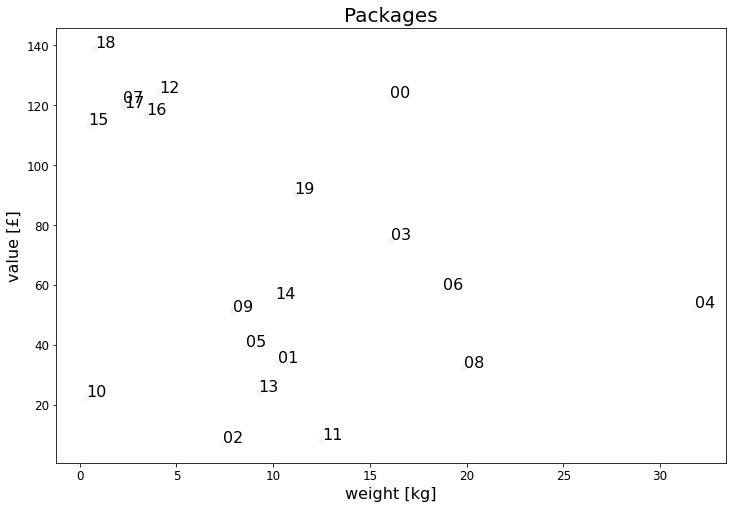

In [5]:
# visualising the package weight-value distribution

plt.scatter([packages[idx_package]['weight'] for idx_package in packages],
            [packages[idx_package]['value'] for idx_package in packages],
            color = 'purple', alpha=0.04
           )

for idx_package, package in packages.items():
    plt.annotate(f'{idx_package:02.0f}', xy=(package['weight'], package['value']), fontsize=MEDIUM_SIZE)
    
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Packages')

#  Decision Space

In optimisation the ***Decision Space*** is defined as the parameters which the user has control over.   

In the knapsack problem we have decide which packages to put in a knapsack.    

If the number of possible package combinations is small enough we can examine (by brute force) all possible knapsacks created by the packages. That is the objective of this notebook. (In the subsequent tutorial we will discuss optimising in an intractable decision space.)  

## Decision Space Size

There are two parameters of interest that decide how many knapsacks are possible: 
* `N_PACKAGES` which was determined in [Packages](#Packages).
* `N_PACKAGES_PER_KNAPSACK` introduced here determines the number of packages that fit into a knapsack.  


We can easily calculate the number of combinations defined as an unordered arrangement of $k$ objects from a set of $n$, which is called  *$n$ choose $k$*.  

which is calculated as:  
$$
_nC_k=\frac{n!}{(n-k)!k!}\equiv {n \choose k}
$$

Here we use     
`k = N_PACKAGES_PER_KNAPSACK`  
`n = N_PACKAGES`,  
with assumptions for simplicity:  
* A package can appear only once in a a knapsack.  
* The order of a package assigned to a knapsack does not matter. 

**Note**  
You do not need to understand the equation above.  
Below you are provided with:   
* a calculator that executes this equation using the `math.factorial` function   
* `itertools.combinations` function that creates all *n-choose-k* combinations. 

**Important!**   
To use `itertools.combinations` to create all *n-choose-k* combinations make sure that the calculator results in a reasonable amount of combinations that you computer can handle. Prior to quantum computing 10,000 should be sufficient. Above that a single processor might struggle to run this notebook.  

In [6]:
# combinations calculator
from math import factorial 

def pretty_int(x):
    if x > 1.e6:
        return f'{int(x):0.1e}'
    else:
        return f'{int(x):,}'

N_PACKAGES_PER_KNAPSACK = 4  # CHANGE ME! (Note! make sure that the number of combinations is below 10,000)
# -----------
    
n = N_PACKAGES
k = N_PACKAGES_PER_KNAPSACK

n_combinations = factorial(n)/factorial(k)/factorial(n-k)

f'There are {pretty_int(n_combinations)} combinations of {n} choose {k}.'

'There are 4,845 combinations of 20 choose 4.'

## Knapsacks

Here we will create the `n_combinations` knapsacks.



<img src="https://www.chatelaine.com/wp-content/uploads/2019/07/5-most-popular-backpacks-feature.jpg" width=500>


Each knapsack contains one possible combination of `N_PACKAGES_PER_KNAPSACK` packages (of the total `N_PACKAGES` packages). 

In [7]:
# Creating a generator object of all the possible knapsacks

# NOTE! Only run this if the number of combinations (as calculated above) is of the order <10,000.
# Beyond that the method used in this notebook might take a long time.

from itertools import combinations 

package_combinations = combinations(packages.keys(), N_PACKAGES_PER_KNAPSACK)

In [8]:
# creating all possible knapsacks
 
knapsacks = {}
for idx_knapsack, this_idxs_packages in enumerate(list(package_combinations)):
    knapsacks[idx_knapsack] = {}
    knapsacks[idx_knapsack]['packages']= this_idxs_packages
            
print('This is what the first four knapsacks look like:')
{idx_knapsack: knapsack for idx_knapsack, knapsack in knapsacks.items() if idx_knapsack<4}

This is what the first four knapsacks look like:


{0: {'packages': (0, 1, 2, 3)},
 1: {'packages': (0, 1, 2, 4)},
 2: {'packages': (0, 1, 2, 5)},
 3: {'packages': (0, 1, 2, 6)}}

In [9]:
print(f'The number of knapsacks {len(knapsacks):,}\nshould be the same as the combination that we previously calculated ({int(n_combinations):,})')

The number of knapsacks 4,845
should be the same as the combination that we previously calculated (4,845)


**Interim Checkpoint**

Can you define:  
* What is the Decision Space? 
* What is the Decision Space for the knapsack problem?  

Bonus question:  
Can you explain why the number of packages per knapsack defines the size of the Decision Space?  

# Objective Space

In optimisation the ***Objective Space*** is defined as the parameters we are interested in optimising for.  


<img src="https://user-images.githubusercontent.com/6064016/97779521-7bada300-1b76-11eb-9ab9-c1aa2eaad477.png" width=500>

The Objective Space is related to the Decision Space via a mapping.

In the knapsack problem we define the Objective Space as the weights of the knapsacks and their content monetary value.   

The mapping from the Decision Space (the packages in each knapsack) is covered in this section using the `knapsack_objective` function.  

Image by [Zitzler et al. (2014)](https://link.springer.com/chapter/10.1007/978-3-642-17144-4_1). 

In [10]:
# calculating the values of the Objective Space
def knapsack_objective(knapsack, objective, packages):
    knapsack[objective] = np.sum([packages[idx_package][objective] for idx_package in knapsack['packages']])
 

objectives = ['weight', 'value']

for idx_knapsack in knapsacks:
    for objective in objectives:
        knapsack_objective(knapsacks[idx_knapsack], objective, packages)
        
print('This is what the first four knapsacks look like now that we added the Objective Space:')
{idx_knapsack: knapsack for idx_knapsack, knapsack in knapsacks.items() if idx_knapsack<4}

This is what the first four knapsacks look like now that we added the Objective Space:


{0: {'packages': (0, 1, 2, 3),
  'weight': 49.83628593060088,
  'value': 239.0966541846496},
 1: {'packages': (0, 1, 2, 4),
  'weight': 65.53925805317334,
  'value': 216.3501454683599},
 2: {'packages': (0, 1, 2, 5),
  'weight': 42.33887271396468,
  'value': 203.48234032759544},
 3: {'packages': (0, 1, 2, 6),
  'weight': 52.4858307695909,
  'value': 222.28173353988964}}

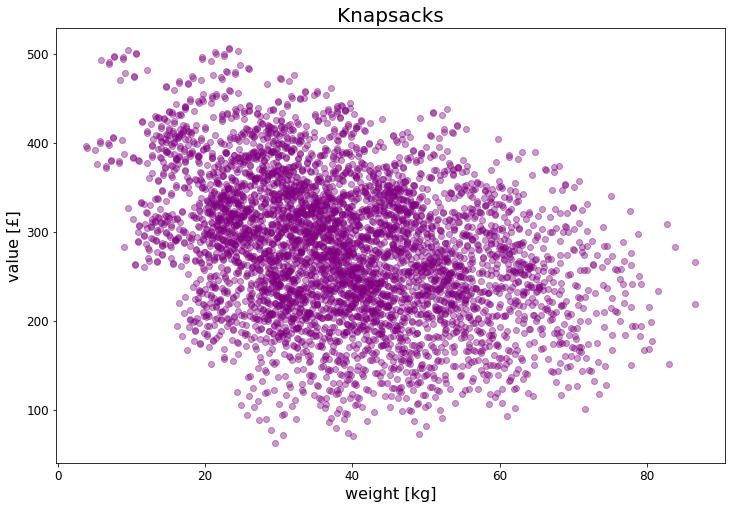

In [11]:
# visualising the Objective Space

plt.scatter([knapsacks[idx]['weight'] for idx in knapsacks], 
            [knapsacks[idx]['value'] for idx in knapsacks], 
            alpha=0.4, color='purple')

plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Knapsacks')
pass

Examine the distribution of knapsacks in the Objective Space of weight and values.  
Assuming that you want to minimise the knapsack weight and maximise the value:  

* Which one knapsack would you consider "optimal"?
* If you had a budget for 5 knapsacks, which ones would you choose as "the best"?

# Optimisation Objective

In the knapsack problem we want to optimise for two objectives:    
* ↓ minimise the knapsack weight 
* ↑ maximise the moentary values of the packages in the knapsack
 
 
**Note**    
The default setting here is ↓↑, but feel free to explore the other combinations: ↓↓, ↑↓ or ↑↑. (See the ***CHANGE ME!*** for `objective_mode`).    

In [12]:
from operator import lt as less_than, gt as greater_than
from operator import (truediv as div, mul)

In [13]:
# Objective Space declaration

# CHANGE ME!
objective_mode, heuristic, soh_unit = {'weight': 'min', 'value': 'max'}, 'value/weight', '£/kg'
#objective_mode, heuristic, soh_unit = {'weight': 'min', 'value': 'min'}, '1/value/weight', '1/£/kg'
#objective_mode, heuristic, soh_unit = {'weight': 'max', 'value': 'max'}, 'value*weight',  '£*kg'
#objective_mode, heuristic, soh_unit = {'weight': 'max', 'value': 'min'}, 'weight/value', 'kg/£'

In [14]:
# These objects are used to calculate the relationships between the knapsacks.

# for Single Objective Optimisation
direction_to_multiplier = {'min': div, 'max': mul}

# for Pareto Optimal selection
mode_to_operator = {'min': less_than, 'max': greater_than}
objective_operator = {key: mode_to_operator[objective_mode[key]] for key in objective_mode.keys()}

# Single Objective Optimal 

Before addressing Pareto Fronts, which help us resolve limitations of 1D approaches, lets examine the common practice of *Single Objective Optimisation*.    

In Single Objective Optimisation we collate the Objective Space to one parameter heuristic, 
turning the multi-objective optimisation problem to 1D.  

In [15]:
# calculating the single objective heuristic for each knapsack (soh) 

def knapsack_to_soh(knapsack):
    # generalising 
    # (weight,value) : returns single-objective-heuristic
    # (↓, ↑) : returns knapsack['value'] / knapsack['weight'] 
    # (↑, ↑) : returns knapsack['value'] * knapsack['weight'] 
    # etc.
    
    value_heuristic    = direction_to_multiplier[objective_mode['value']](1, knapsack['value'])
    weight_heuristic   = direction_to_multiplier[objective_mode['weight']](1, knapsack['weight'])
    return  value_heuristic * weight_heuristic

knapsacks_soh = {iknapsack: knapsack_to_soh(knapsack) for iknapsack, knapsack in knapsacks.items()}

Lets examine the distribution of this heuristic with a histogram.

Text(0, 0.5, 'Knapsacks')

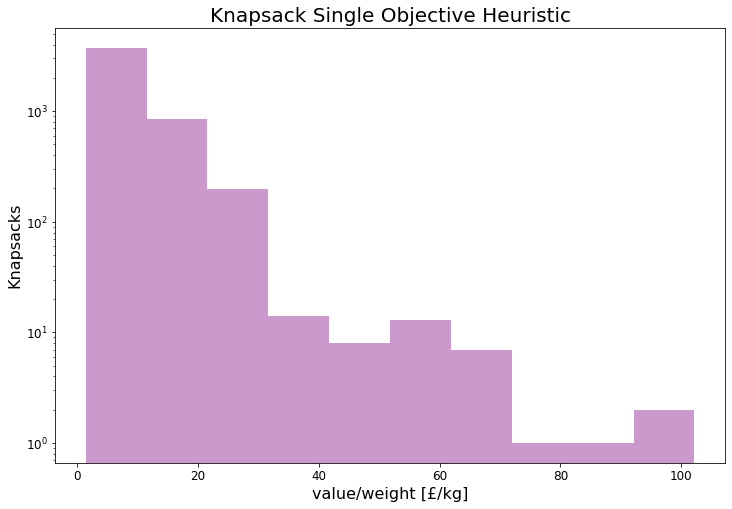

In [16]:
# visualising the histogram of all the single objective heuristic values

plt.hist(list(knapsacks_soh.values()), alpha=0.4, color='purple')
plt.xlabel(f'{heuristic} [{soh_unit}]')
plt.title('Knapsack Single Objective Heuristic')
plt.yscale('log')
plt.ylabel('Knapsacks')

The single objective optimal knapsack will be the one with the maximum value of the heuristic.  
We'll find which one this is here. 

In [17]:
# identifying the knapsack with the highest soh.

# soh - single objective heuristic
# soo - single objective optimal

max_soh = -1
iknapsack_soo = None

for iknapsack, soh in knapsacks_soh.items():
    if soh > max_soh:
        iknapsack_soo = int(iknapsack)
        max_soh = float(soh)
        
print(f'For Single Objective Optimisation \nknapsack {iknapsack_soo} is considered "optimal" with a heuristic value of {max_soh:0.1f}{soh_unit}.')

For Single Objective Optimisation 
knapsack 4258 is considered "optimal" with a heuristic value of 102.2£/kg.


**Interim Summary**  

This is the stage where a lot analyses stop and decisions are made.  

For a budge of $N$ best solutions, the process so far has been:  
* combining multiple parameters into a single heuristic
* sorting all solutions according to this heuristic
* selecting the top ($N\geq1$) solutions as "optimal".  


Whereas this technique is quite intuitive, easy to apply and broadly used, it comes with one main flaw:

> It limits the view of the objective space, possibly resuting in suboptimal results.  

In other words, this procedure is stopping short from a true in-depth exploration of that decision-objective spaces.   
The 1D histogram above is the equivalent of horse blinders. 

<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/Horses_2.jpg" width=150>

Let's examine scatter plots in our full objective space (in our case 2D) to get the birds eye view, which will enable us to see more interesting aspects of the Objective Space than the histogram can.

<img src="https://i.ytimg.com/vi/D1gG9aLKXBw/hqdefault.jpg" width=300>


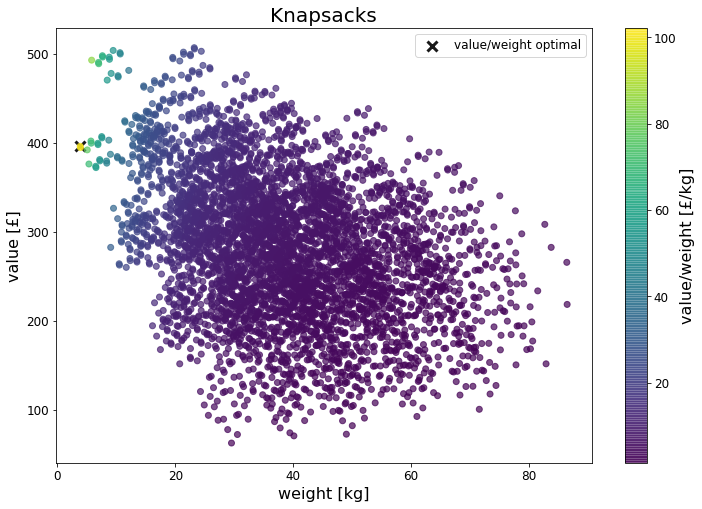

In [18]:
# visualising the weight-value distribution color coded by the heuristic

plt.scatter(knapsacks[iknapsack_soo]['weight'], knapsacks[iknapsack_soo]['value'], 
            marker='x', s=100, alpha=0.9, label=f'{heuristic} optimal', color='black', linewidth=3)

plt.scatter([knapsacks[idx]['weight'] for idx in knapsacks], 
            [knapsacks[idx]['value'] for idx in knapsacks], 
            alpha=0.7, c=np.array(list(knapsacks_soh.values())), cmap='viridis')

plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Knapsacks')
plt.colorbar(label=f'{heuristic} [{soh_unit}]')
plt.legend()

In the above we see that the Single Objective Optimiser selected one regions of possible interest, but perhaps we can do better? Pareto Fronts help us gauge better decisions. 

# Pareto Optimal Solutions
Here you will apply and visualise a Pareto Front algorithm to find solutions that are called *Pareto Optimal*.


In the Single Objective Optimisation approach we pre-determined the relationship between the objectives `value` and `weights` prior to creating the heuristic which we used to select the "best/optimal" solution(s).  

An alternative approach is to be agnostic, where we treat the objectives as independent/orthogonal. In most real life problems we do not know the relationships between the objectives. E.g, imagine in the case of the knapsack problem that we do not know the monetary value of the weight.   

This means that we can examine the actual distribution in the Objective Space and find solutions (knapsacks) that are *Non Dominated*, which we call *Pareto Optimal*.  

Let's define these using the diagram below in which we want to maximise for both objectives.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/Pareto_Efficient_Frontier_1024x1024.png" width=300>

* ***Dominated*** solutions (in gray) are those for which we can find at least one other solution that dominates in all objectives.  
E.g, solution $K$ is dominated by solution $D$ which has higher values in both objectives. There are actually 3 more solutions that dominate $K$. Can you identify all of them?  

* ***Non Dominated*** solutions (in red; also called ***Pareto Optimal***) are those for which there is no other solution that dominates it in all the objectives.  
E.g, solution $C$ is not dominated by any other solution in respect to all the objectives. It is dominated by $B$ in the objective 2, but not by objective 1. Solution $D$ dominates $C$ by objective 1 but not by 2. Solutions $B$ and $D$  do not dominate $C$ in both and hence the latter is considered Pareto Optimal. 

**Pareto Front**

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/Vilfredo_Pareto_1870s2.jpg" width=100>



Named after the engineer and economist [Vilfredo Pareto](https://en.wikipedia.org/wiki/Vilfredo_Pareto), we define the Pareto Front as the set of Non Dominated solutions, and consider them (at first*) as equally optimal trade-off solutions.

*We will eventually have to apply a subjective ranking. This will be decissed in [Decision Making With Pareto Fronts](#Decision-Making-With-Pareto-Fronts). 

Now that we know what Pareto Optimal solutions are let's see how we calculate them.  

Before using an algorithm in Python let's examine its pseudocode. 

**Pareto Front Pseudo Code**  

* Input: `knapsacks` is a list of knapsack objects each with properties `weight`, `value`.  
* Output: `pareto_front` is subset list of  `knapsacks` containing Pareto optimal solutions that minimises  `weight` and maximises `value`.  

```python
--- start ---
pareto_front = []

for this_knapsack in knapsacks:
    is_pareto = True   # we assume that this_knapsack is Pareto Optimal until proven otherwise
    
    other_knapsacks = knapsacks.remove(this_knapsack)
    
    for other_knapsack in other_knapsacks:
        # Does `other_knapsack` dominate `this_knapsack`?  
        other_dominates  = this_knapsack['weight'] > other_knapsacks['weight']
        other_dominates &= this_knapsack['value'] < other_knapsacks['value']
        
        if other_dominates:
            # knapsack dominated by at least one other knapsack, hence not pareto optimal
            is_pareto = False
            break  #  no need to compare with the rest of the other knapsacks
            
    if is_pareto:
        pareto_front.append(this_knapsack)     
--- end ---
```

**Note**  
Our focus is on two objectives, but this is easily generalised to more by adding lines:  `other_dominates &= ...`. 


In [19]:
# setting up the environment for the calculation of the Pareto Front
# objective_values contains the values of the objectives of the knapsacks in the same order of the knapsacks object

objective_values = {}

for objective in objectives:
    objective_values[objective] = [knapsacks[idx][objective] for idx in knapsacks]

objective_values.keys()

dict_keys(['weight', 'value'])

In [20]:
# The Pareto Front calculation

idxs_pareto = []  # stores the indices of the Pareto optimal knapsacks

for idx in range(len(objective_values[objective])):
    is_pareto = True  #  we assume on Pareto Front until proven otherwise
    
    # objective values of this knapsack
    this_weight = objective_values['weight'][idx]
    this_value = objective_values['value'][idx]
    
    # objective values of all the other knapsacks
    other_weights = np.array(objective_values['weight'][:idx] + objective_values['weight'][idx + 1:])
    other_values = np.array(objective_values['value'][:idx] + objective_values['value'][idx + 1:])
    
    for jdx in range(len(other_weights)):
        other_dominates = objective_operator['weight'](other_weights[jdx], this_weight) & objective_operator['value'](other_values[jdx], this_value)   
        
        if other_dominates:
            #  knapsack dominated by at least another, hence not pareto optimal.
            is_pareto = False
            break  #  no need to compare with the rest of the other knapsacks
            
    if is_pareto:
        idxs_pareto.append(idx)

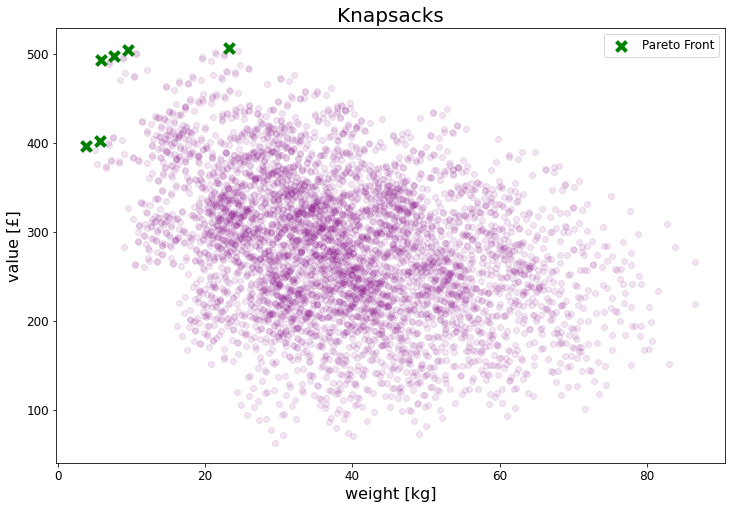

In [21]:
# visualising all the solutions with an emphasis on the Pareto Front

plt.scatter([knapsacks[idx]['weight'] for idx in knapsacks], [knapsacks[idx]['value'] for idx in knapsacks], alpha=0.1, color='purple')
plt.scatter([knapsacks[idx]['weight'] for idx in idxs_pareto], [knapsacks[idx]['value'] for idx in idxs_pareto], 
            marker='x', s=100, linewidth=4, color='green', label='Pareto Front')

plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Knapsacks')
plt.legend()

Recall that the above is the Objective Space.  

Let's examine the Pareto Optimal solutions in the Decision Space, i.e, the packages chosen of the optimal knapsacks.  

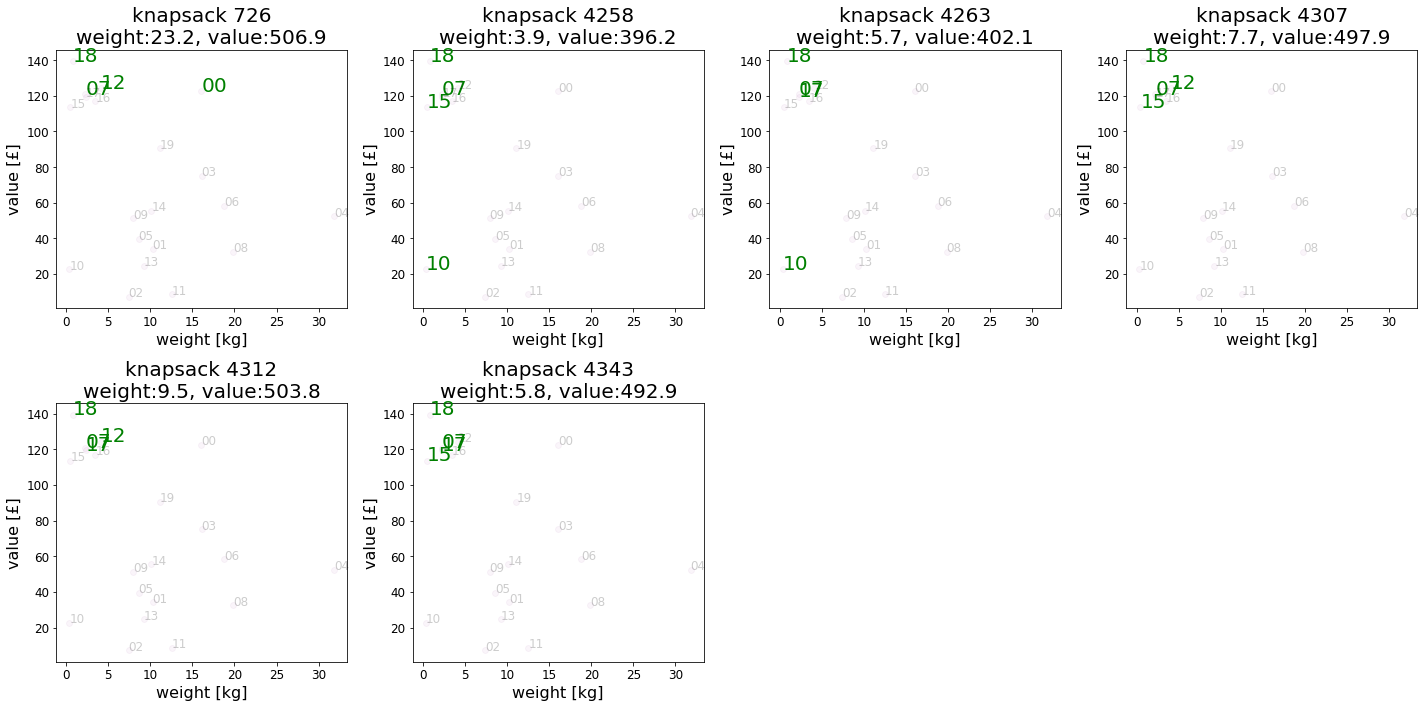

In [22]:
# visualising the Decision Space. each panel emphasises the packages for one Pareto optimal knapsack

max_panels = 8
if len(idxs_pareto) > max_panels:
    np.random.seed(seed)
    idxs_pareto_plot = np.random.choice(idxs_pareto, max_panels, replace=False)
else:
    idxs_pareto_plot = idxs_pareto
    
npanels = len(idxs_pareto_plot)


ncols = 4
nrows = npanels // ncols + np.sum( (npanels % ncols) != 0)

plt.figure(figsize = (5 * ncols, 5 * nrows))

for ipanel, idx_pareto in enumerate(idxs_pareto_plot):
    plt.subplot(nrows, ncols, ipanel + 1)
    
    idx_packages_pareto = knapsacks[idx_pareto]['packages']

    plt.scatter([packages[idx_package]['weight'] for idx_package in packages],
                [packages[idx_package]['value'] for idx_package in packages],
                color = 'purple', alpha=0.04
               )

    idx_packages_pareto = knapsacks[idx_pareto]['packages']

    for idx_package, package in packages.items():

        if idx_package in idx_packages_pareto:
            plt.annotate(f'{idx_package:02.0f}', xy=(package['weight'], package['value']), color='green', fontsize=20)
        else:
            plt.annotate(f'{idx_package:02.0f}', xy=(package['weight'], package['value']), alpha=0.2)
    
    title = f'knapsack {idx_pareto}'
    title += f'\nweight:{knapsacks[idx_pareto]["weight"]:0.1f}, value:{knapsacks[idx_pareto]["value"]:0.1f}'
    plt.title(title)
    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')
    

plt.tight_layout()

# Summary

Here we summarise the lessons from our brute force aproach to exploring the solution space.

* During the optimisation process we are required to make a subjective decision in regards to selection of the "optimal" or "best" solution(s).  

* In the Single Objective Optimisation approach we make an a-priori decision about the relationships between the objectives. This exposes the decision maker to a narrow point of view of the options, which might result in a choice that, otherwise, might be considered sub-optimal.  

* To avoid this issue it is recommended to first treat the objectves as independent, which will enable examination of the full Objective Space. This is likely to result in a better decision.  

* To this end, a useful tool for decision makeing is The Pareto Front, which is defined a set of equally-optimal trade-off Non Dominated (Pareto Optimal) solutions.  


Congratulations! 
You have just learned the fundamentals of Pareto Fronts.

To further grasp some of the points made, you are encouraged to explore different distributions and set different objectives. Below is a a suggested list of actions you can take to further learn the topic. Choose one that seems interesting to you, update the notebook and rerun the cells to see how the results vary.

**Actions To Take**

- [ ] Change the optimisation objective to minimising both weight and monetary value.   
This is done, e.g, by setting `objective_mode={'weight': 'min', 'value': 'min'}` in [Optimisation Objective](#Optimisation-Objective).   
Try to guess in advance which knapsacks are considered Pareto Optimal!   
Try all four combinations.  
- [ ] Examine the $value\sim weight^2$ distribution by modifying `value_distribution_mode="squared"` in [Packages](#Packages).
- [ ] Create your own distribution! Create your own custom `value_distribution_mode` in [Packages](#Packages). 

# Decision Making With Pareto Fronts

Once the Pareto Front is identified a decision has to be made about selection of the $N$ best solutions.  
In other words, now is the time to apply a subjective decsion which will determine how we rank the solutions.  

How to select, of course, will depend on the project budget and objectives but broadly speaking the subjective decision will be determined by:

* The $N$ number of solutions that will be used for the next step. In our example, you might have four knapsack carriers, so you will want to give each one knapsack.   
* After examining the exhaustive solution space the decision maker might apply weights. This results in a single heuristic reducing the problem to Single Objective Optimisation. 
* The decision maker might decide to narrow in on solutions in one or multiple regions. Otherwise they could sample across the Pareto Front.  

**Note**  
Here the term *decision maker* is used broadly. The meaning is someone with domain expertise who could be anyone from the analyst, to someone non technical that understands the field. 


**Note 2**  
Here we focus on an Objective Space that has two parameters ($2D$). Ideas here can be naturally extrapolated to higher dimensions (3 or more objectives), although this might be more challenging to visualise. One mechanism is visualising 2D slices, and color coding a 3rd dimension.   


*For your own amusement (and education) I highly recommend watching [The Expert](https://www.youtube.com/watch?v=ObA9WGiQqLY&ab_channel=Adnan). This was recommended to me in during transition from academia to the private sector, and is an excellent life lesson on (mis)communication in a professional environment.  


# Next Up: Rerun With A Larger Search Space!

In this tutorial we focused on learning about the Pareto Front in an exhaustive search setting, i.e, where we can brute force our way to the full solution space.  

In reality, however, you are likley to deal with much larger combinatorial spaces.  

Play around with this calculator to see how large the Knapsack problem can get by modfiying `N_PACKAGES` and `N_PACKAGES_PER_KNAPSACK`.  

In [23]:
# if you set N_PACKAGES=20,000, N_PACKAGES_PER_KNAPSACK=30 you get 
# 4e+96 knapsacks, i.e, more package combinations than atoms in the observable universe! (estimated e+78 to e+82)

N_PACKAGES = 20000 
N_PACKAGES_PER_KNAPSACK = 30
# -----------
    
n = N_PACKAGES
k = N_PACKAGES_PER_KNAPSACK

n_combinations = factorial(n)//factorial(k)//factorial(n-k)

f'There are {pretty_int(n_combinations)} combinations of {n} choose {k}.'

'There are 4.0e+96 combinations of 20000 choose 30.'

In the case of a large intractable objective space we will need to use a stochastic method to navigate the combinatorial space.  

We will explore this in the next tutorial, which is accessible in Google Colab. To access press this button: 

<a href="https://bit.ly/genetic-algorithm-colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="First: Open In Colab"/></a>